# The purpose of this notebook is to create a monte carlo simulation of blackjack

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Custom Modules.
from Game import Game
from Player import Player

# Custom Functions.
from RecursePlayer import recursePlayer,dealHouse,getReward,getValue
from Q_Learning import initQ,learnPolicy,evaluatePolicy,getBestAction
from Utils import dfBestMove

# Rewards Distribution

Given random gameplay, what are the expected reward for each state-action pair?

### Here, I can specifically state which combinations I want played. However, right now, I assume plentiful cards. Will not serve as optimal policy evaluation, but rather expected rewards given a state - action pair.

So, every combination is possible (hardcoded in), and the next card drawn is uniformly, with replacement. 

Might introduce some bias. Imagine player shows [2,2], the odds of them drawing another 2 should be lower, but this method does not say so.

I use discounted rewards. For example:
- Player shows 5, they hit to get 9, hit to get 12, hit to get 20, stay, and ends up winning the hand.
- I'm most interested in the move taken when player has 20.
- How I handle this is by using the gamma hyperparameter and discounting earlier moves more

Initialize the simulation

In [72]:
blackjack = Game(Player)
cardMap = blackjack.cardMap
cardValues = blackjack.cardValues
allCards = list(cardMap.values())

moves = ['stay','hit','double','surrender','split']

pairsSplit = {(c,c):i for i,c in enumerate(allCards)}
pairsSplit = {}
count = 0
for c in allCards :
    pairsSplit[(c,c)] = count
    if c not in [10,'J','Q'] :
        count += 1
    

# initialize arrays for totals + rewards
# dimensions are (m,a,p,h)
# - m : # of possible moves
# - a : useable ace or not
# - p : # of possible totals (includes 0,1,2,3 for simplicity), PLUS # of pairs
# - h : # of possible house face-up card (includes 0,1,2,3 for simplicity)

totals = np.zeros((len(moves),2,21+1+len(pairsSplit)-3,11+1))
rewards = np.zeros((len(moves),2,21+1+len(pairsSplit)-3,11+1))

gamma = .7

nTrials = 2000

Run the trail

In [6]:
for n in range(nTrials) :
    print('{} of {}'.format(n,nTrials),end='\r')
    for i in range(len(allCards)) :
        for j in range(i,len(allCards)) :
            cards = [allCards[i],allCards[j]]
            for h in range(len(allCards)) :
                houseCards,val,houseShow = dealHouse(allCards[h],cardMap,cardValues)
                seriesOut = recursePlayer(cards,allCards[h],cardMap,cardValues)

                for r in seriesOut :
                    if len(r)==0 :
                        totals[0,0,21,houseShow] += 1
                        rewards[0,0,21,houseShow] += 1.5
                        continue
                    reward = getReward(r,val)
                    
                    # I can discount earlier moves (hence reversing the order of moves)
                    # to more accurately reflect the benefit of hitting on smaller player cards shown.
                    for g,(playerShow,move,useableAce,pairSplit,nextVal) in enumerate(r[::-1]) :
                        indPlayer = playerShow
                        if pairSplit :
                            indPlayer = 22 + pairsSplit[tuple(pairSplit)]
                        totals[moves.index(move),int(useableAce),indPlayer,houseShow] += 1   
                        rewards[moves.index(move),int(useableAce),indPlayer,houseShow] += reward*gamma**g
            
            
normalized = np.zeros(totals.shape)
for m in range(len(moves)) :
    for i in [0,1] :
        # prevent division by zero, clip totals (shouldn't happen if # iterations is high enough)
        normalized[m][i] = rewards[m][i] / np.clip(totals[m][i],a_min=1,a_max=None)
            
            
        

In [13]:
#np.save('normalized.npy',normalized)
normalized = np.load('normalized.npy')

In [4]:
noAce,useableAce,canSplit = dfBestMove(normalized,moves,pairsSplit,colorBox=True)

In [5]:
noAce

,2,3,4,5,6,7,8,9,10,11
5,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
6,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
7,Hi,Hi,Hi,Hi,Do,Hi,Hi,Hi,Hi,Hi
8,Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
9,Do,Do,Do,Do,Do,Do,Do,Hi,Hi,Hi
10,Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
11,Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
12,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi
13,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi
14,St,St,St,St,St,Hi,Hi,Hi,Hi,Su


In [6]:
useableAce

,2,3,4,5,6,7,8,9,10,11
13,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
14,Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
15,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
16,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
17,Do,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi
18,St,Do,Do,Do,Do,St,St,St,St,Hi
19,St,St,St,St,St,St,St,St,St,St
20,St,St,St,St,St,St,St,St,St,St
21,St,St,St,St,St,St,St,St,St,St


In [7]:
canSplit

,2,3,4,5,6,7,8,9,10,11
"(2, 2)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi,Hi
"(3, 3)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi
"(4, 4)",Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
"(5, 5)",Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
"(6, 6)",Sp,Sp,Sp,St,St,Sp,Sp,Sp,Sp,Sp
"(7, 7)",Sp,Sp,Sp,St,St,Sp,Sp,Sp,Sp,Sp
"(8, 8)",Sp,Sp,Sp,St,St,Sp,Sp,Sp,Sp,Sp
"(9, 9)",St,St,St,St,St,St,St,St,St,St
"(10, 10)",St,St,St,St,St,St,St,St,St,St
"('A', 'A')",Sp,Sp,Do,Do,Do,Sp,Sp,Sp,Sp,Sp


# Policy Generation (Control)

Can I learn an optimal policy using Monte Carlo methods?
- Greedy Algorithm
    - Always take the best action. In my code, it's equivalent to setting epsilon to -1
- Epsilon-Greedy Algorithm
    - With probability=epsilon, randomly take action. Otherwise, take best action
    - I allow epsilon to decay through learning. Meaning, Always explore at first, then start to exploit more.
- Thompson Sampling methods.
    - In my situation, this is handled by setting always_random=True
    - The probability of an action is chosen according to the learned Q value distribution over actions.
    - I normalize Q values by taking softmax of Q values.


I find that always_random=True leads to faster training than in epsilon decay.

I store "bestQ" at each interval of evaluation (expensive function, since I simulate 1000 rounds to evaluate).
So, Backtracking will be performed until number of rounds is complete.

#### Simulate game play, gather totals and rewards, normalized rewards, and display best option.

In [181]:
card_comb_all = []
card_comb = [[c1,c2] for i,c1 in enumerate(allCards) for c2 in allCards[i:]]
all_comb = [[c1,c2] for c1 in allCards for c2 in allCards]
for c in card_comb :
    for a in all_comb :
        card_comb_all.append([[c]]+[a])

In [255]:
Q = {
    'name':'e-Greedy Decay 1',
    'epsilon_decay':.00001,
    'min_epsilon':.1,
    'evaluation':[]
}

nEpisodes = int(5e5) # number of rounds to train for.
nPlayers = 1 # number of players
gamma = .8 # decay hyperparameter. How much to discount sequential actions.
lr = .01
nDecks = 6
ratioPenetrate = 4/6
wagers = [1]*nPlayers

nRoundsEvaluate = 1000 # number of hands to play during evaluation step

moves = ['stay','hit','split','double','surrender']

earlyStop = False
e = 10 # early stopping criterion. Number of "every" that have to pass without improvement.
every = int(len(card_comb_all)/5) # interval to evaluate policy

# will intermittently store best Q values through evaluation
backtrack = False

# will override epsilon value and sample from action space according to Q values.
always_random = True

# since some combinations are so rare, they are hardly explored. 
# Setting to True will force these combinations to be used.
# I have found that without hardcoding, there is hardly any information in many of the states.
allow_hardcoded_cards = True 


In [256]:
blackjack = Game(
    Player,
    allowHardCodedCards=allow_hardcoded_cards,
    shrinkDeck=True,
    nDecks=nDecks,
    ratioPenetrate=ratioPenetrate,
    verbose=False
)

allCards = list(blackjack.cardMap.values())
Q['Q'] = initQ(moves,allCards)

r = 0
counter = 0
minPerformance = -10
while r < nEpisodes :
    
    # force exploration of space
    # since some combinations were never occuring, I still want some notion of how to move.
    # introduces some "error", as it's possible not enough cards are in the deck.
    # I say it's acceptable for 1 move, then a reshuffling will occur after.
    # I see better learning with this method anyways.
    card_comb_use = card_comb_all[r%len(card_comb_all)]

    blackjack.initRound(wagers)
    if allow_hardcoded_cards :
        blackjack.dealInit(hardcodedCards=card_comb_use) # force certain cards to be explored.
    else :
        blackjack.dealInit()
    if not blackjack.houseBlackjack :
        eps = max(Q['min_epsilon'],np.exp(-Q['epsilon_decay']*r)) #exponential decay factor.
        learnPolicy(blackjack,Q['Q'],nPlayers,eps,gamma,lr,always_random=always_random)

    if not r%every :
        blackjackEval = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
        # Evaluation. This represents the avg reward, per hand, for the number of rounds specified.
        p = np.mean(evaluatePolicy(blackjackEval,Q['Q'],wagers,nRoundsEvaluate)[-1])
        Q['evaluation'].append(p)

        print('Method {} ---- {} of {} ---- EPS : {} ---- Score : {}'.format(Q['name'],r+1,nEpisodes,eps,p))

        if p < minPerformance : 
            counter += 1
        else :
            counter = 0
            if backtrack :
                bestQ = Q['Q'].copy() # "backtracking". This will be used as optimal Q value dict. 
        minPerformance = max(minPerformance,p)

    if (earlyStop) & (counter == e) :

        print('Early Stopping at Round {}.'.format(r))
        break

    r += 1
if not backtrack : # without backtracking, just take final Q values.
    bestQ = Q['Q'].copy()

Method e-Greedy Decay 1 ---- 1 of 500000 ---- EPS : 1.0 ---- Score : -0.3965
Method e-Greedy Decay 1 ---- 3076 of 500000 ---- EPS : 0.9697179722679314 ---- Score : -0.279
Method e-Greedy Decay 1 ---- 6151 of 500000 ---- EPS : 0.9403529457394286 ---- Score : -0.2285
Method e-Greedy Decay 1 ---- 9226 of 500000 ---- EPS : 0.911877151758615 ---- Score : -0.1025
Method e-Greedy Decay 1 ---- 12301 of 500000 ---- EPS : 0.8842636625608209 ---- Score : -0.175
Method e-Greedy Decay 1 ---- 15376 of 500000 ---- EPS : 0.8575035157075082 ---- Score : -0.129
Method e-Greedy Decay 1 ---- 18451 of 500000 ---- EPS : 0.831519939899404 ---- Score : -0.0365
Method e-Greedy Decay 1 ---- 21526 of 500000 ---- EPS : 0.8063398300196023 ---- Score : -0.0765
Method e-Greedy Decay 1 ---- 24601 of 500000 ---- EPS : 0.7819222249254772 ---- Score : -0.0785
Method e-Greedy Decay 1 ---- 27676 of 500000 ---- EPS : 0.7582440344259632 ---- Score : -0.059
Method e-Greedy Decay 1 ---- 30751 of 500000 ---- EPS : 0.7352828675

Method e-Greedy Decay 1 ---- 270601 of 500000 ---- EPS : 0.1 ---- Score : 0.031
Method e-Greedy Decay 1 ---- 273676 of 500000 ---- EPS : 0.1 ---- Score : -0.0195
Method e-Greedy Decay 1 ---- 276751 of 500000 ---- EPS : 0.1 ---- Score : -0.0145
Method e-Greedy Decay 1 ---- 279826 of 500000 ---- EPS : 0.1 ---- Score : 0.0225
Method e-Greedy Decay 1 ---- 282901 of 500000 ---- EPS : 0.1 ---- Score : 0.0315
Method e-Greedy Decay 1 ---- 285976 of 500000 ---- EPS : 0.1 ---- Score : 0.02
Method e-Greedy Decay 1 ---- 289051 of 500000 ---- EPS : 0.1 ---- Score : -0.008
Method e-Greedy Decay 1 ---- 292126 of 500000 ---- EPS : 0.1 ---- Score : 0.016
Method e-Greedy Decay 1 ---- 295201 of 500000 ---- EPS : 0.1 ---- Score : 0.0275
Method e-Greedy Decay 1 ---- 298276 of 500000 ---- EPS : 0.1 ---- Score : -0.0645
Method e-Greedy Decay 1 ---- 301351 of 500000 ---- EPS : 0.1 ---- Score : 0.028
Method e-Greedy Decay 1 ---- 304426 of 500000 ---- EPS : 0.1 ---- Score : -0.0105
Method e-Greedy Decay 1 ---- 

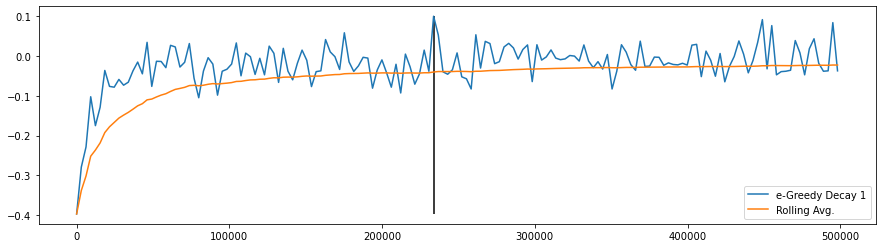

In [257]:
plt.figure(figsize=(15,4))
plt.plot(
    np.arange(0,len(Q['evaluation']))*every,
    Q['evaluation'],
    label=Q['name']
)
plt.plot(
    np.arange(0,len(Q['evaluation']))*every,
    np.cumsum(Q['evaluation']) / np.arange(1,len(Q['evaluation'])+1),
    label='Rolling Avg.'
)
plt.vlines(x=np.argmax(Q['evaluation'])*every,ymin=min(Q['evaluation']),ymax=max(Q['evaluation']),color='k')

plt.legend()
plt.show()

In [258]:
np.save('Q',bestQ)
Qlearned = np.load('Q.npy',allow_pickle=True).item()

### Evaluate new policy, as well as a random one, and a simple one.

It is apparent that the learned policy performs better in practice than a random one, and a "simple" one. In the "simple" one, I create a basic strategy where the player hits until they have >17

Generating Random Rewards...
Generating Learned Rewards Deterministically...
Generating Learned Rewards w Sampling...
Generating Meh Rewards...
Done


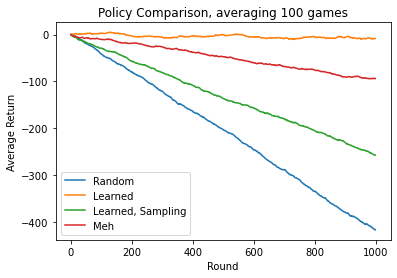

In [259]:
nRoundsEvaluate = 1000 # number of rounds to play
nIterations = 10 # number of times to play above number of rounds (average is taken)

print('Generating Random Rewards...')
randQ = initQ(['stay','hit','split','double','insurance','surrender'],allCards)
blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
randomRewards = np.mean(
    [np.cumsum(evaluatePolicy(blackjack,randQ,wagers,nRoundsEvaluate)[0]) for _ in range(nIterations)],
    axis=0
)

print('Generating Learned Rewards Deterministically...')
blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
try : # if Qlearned has been defined, read in from file, else use the Q dict trained in this notebook.
    learnedRewards = np.mean(
        [np.cumsum(evaluatePolicy(blackjack,Qlearned,wagers,nRoundsEvaluate)[0]) for _ in range(nIterations)],
        axis=0
    )
except :
    learnedRewards = np.mean(
        [np.cumsum(evaluatePolicy(blackjack,bestQ,wagers,nRoundsEvaluate)[0]) for _ in range(nIterations)],
        axis=0
    )

print('Generating Learned Rewards w Sampling...')
blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
try : # if Qlearned has been defined, read in from file, else use the Q dict trained in this notebook.
    learnedRewards_Sampling = np.mean(
        [np.cumsum(evaluatePolicy(blackjack,Qlearned,wagers,nRoundsEvaluate,True)[0]) for _ in range(nIterations)],
        axis=0
    )
except :
    learnedRewards_Sampling = np.mean(
        [np.cumsum(evaluatePolicy(blackjack,bestQ,wagers,nRoundsEvaluate)[0]) for _ in range(nIterations)],
        axis=0
    )
    
print('Generating Meh Rewards...')
somewhatSmartQ = initQ(['stay','hit','split','double','insurance','surrender'],allCards)
for split,s_pairs in somewhatSmartQ.items() :
    for s,vals in s_pairs.items() :
        p,h,a = s
        if split=='canSplit' :
            if p == 'A' :
                p = 12
            else :
                p = p*2
        if p > 17 :
            vals['stay'] = 1
        else :
            vals['hit'] = 1

blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
mehRewards = np.mean(
    [np.cumsum(evaluatePolicy(blackjack,somewhatSmartQ,wagers,nRoundsEvaluate)[0]) for _ in range(nIterations)],
    axis=0
)
print('Done')

plt.title('Policy Comparison, averaging 100 games')
plt.plot(randomRewards,label='Random')
plt.plot(learnedRewards,label='Learned')
plt.plot(learnedRewards_Sampling,label='Learned, Sampling')
plt.plot(mehRewards,label='Meh')
plt.xlabel('Round')
plt.ylabel('Average Return')
plt.legend()
plt.show()

### While sampling helped in training Q values, it's clear that we should deterministically take actions best on best Q value at that state/action pair.

Below, I show the cummulative rewards for a different players playing blackjack for many rounds according to our learned policy.

There is clearly a ton of randomness going on. This is the nature of blackjack.

Important to note that we are able to minimize risk through this learned policy. We go from a net -0.4 units lost per round with a random policy, to achieving what seems to be no-loss per round, on average.

**This doesn't even take card count into account**

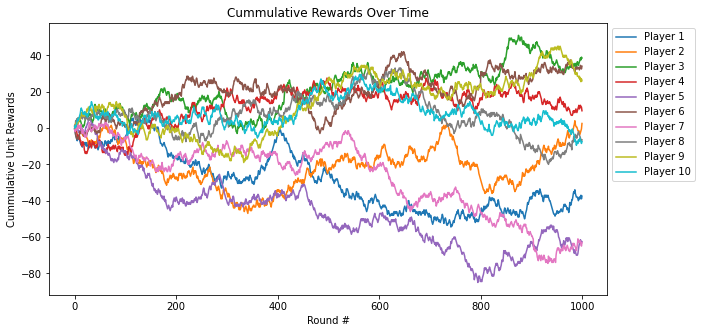

In [261]:
plt.figure(figsize=(10,5))

for i in range(10) :
    blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
    try : # if Qlearned has been defined, read in from file, else use the Q dict trained in this notebook.
        r = np.cumsum(evaluatePolicy(blackjack,Qlearned,wagers,nRoundsEvaluate)[0])
    except :
        r = np.cumsum(evaluatePolicy(blackjack,bestQ,wagers,nRoundsEvaluate)[0])
    plt.plot(r,label='Player {}'.format(i+1))
plt.legend(bbox_to_anchor=[1, 1])
plt.title('Cummulative Rewards Over Time')
plt.xlabel('Round #')
plt.ylabel('Cummulative Unit Rewards')
plt.show()

### Give an example of playing a hand according to learned policy.

You can see the sequence of events taken by the player, the sequence of events taken by the house, the outcome, and the unit reward

In [235]:
blackjack = Game(Player,verbose=False)

blackjack.initRound(wagers=[1])
blackjack.dealInit()
player = blackjack.players[0] # only 1 player, so i'll just extract that specific player module.
houseShow = blackjack.getHouseShow(showValue=True)

print('Player Cards / Moves:')
while not player.isDone() :

    playerShow,canSplit,useableAce,card1 = player.getValue()

    policy = player.getValidMoves(houseShow)
    policy = [p for p in policy if p!='insurance']
    try :
        if canSplit :
            move = getBestAction(Qlearned['canSplit'][(card1,houseShow,useableAce)],policy,-1,False)
        else :
            move = getBestAction(Qlearned['noSplit'][(playerShow,houseShow,useableAce)],policy,-1,False)
    except :
        if canSplit :
            move = getBestAction(bestQ['canSplit'][(card1,houseShow,useableAce)],policy,-1,False)
        else :
            move = getBestAction(bestQ['noSplit'][(playerShow,houseShow,useableAce)],policy,-1,False)
    print(player.cards,move)
    
    blackjack.stepPlayer(player,move)

if move != 'stay' :
    print(player.cards)

blackjack.stepHouse()

print('\nHouse Cards / Moves:')
print(blackjack.house.cards)
print('\nResult:')
blackjack.getResults()

Player Cards / Moves:
[[6, 9]] stay

House Cards / Moves:
[[4, 'K', 'Q']]

Result:


([['win']], [1])

## Evaluation

In [3]:
Qlearned = np.load('Q.npy',allow_pickle=True).item()

In [9]:
fill = np.empty((3,21+1,11+1),dtype='O')
value_det = np.zeros((3,21+1,11+1))

### First I can show the Value function

Two ways:
- Deterministic Action. Select best action. ie. P=1 for best action, else P=0
- Random Action. Best action is selected according to normalized q values

$V_{\pi}(s)$ tells us, according to a policy $\pi$, how "good" is it to be in state $s$
$$
V_{\pi}(s) = E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s\right]
$$

$Q_{\pi}(s,a)$ tells us, according to a policy $\pi$, how "good" is it to be in state $s$ and take action $a$
$$
Q_{\pi}(s,a) = E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s, a_t=a\right]
$$

We can relate $V$ and $Q$ by taking marginal expections over $a$

$$V_{\pi}(s) = E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s\right]$$

$$V_{\pi}(s) = E_a\left[E_{\pi}\left[\sum_{t=0}^{T}\gamma^tr_t | s_t = s, a_t=a\right] \right]$$

$$V_{\pi}(s) = E_a\left[Q_{\pi}(s,a)\right]$$

$$V_{\pi}(s) = \sum_{a}\pi(s,a)Q(s,a)$$

Where $\pi(s,a)$ is the probability of taking action $a$ in state $s$

In my case, I allow for randomization in action during Q learning. However, in evaluation, I always take the optimal action, which is deterministic

In practice, the action is taken that maximizes the Q value given the current state, deterministically.

In [10]:
# Two ways to define value function
# 1. Deterministic. Pick best action
# 2. Random. Pick best action according to probability, which is normalized from possible q-values

for k,v in Qlearned['noSplit'].items() :
    p,h,a = k
    fill[int(a),p,h] = max(v,key=v.get)[:2].title()
    value_det[int(a),p,h] = max(v.values()) # Deterministic    
for k,v in Qlearned['canSplit'].items() :
    p,h,a = k
    if not isinstance(p,int) :
        p = 11
    fill[2,p,h] = max(v,key=v.get)[:2].title()
    value_det[2,p,h] = max(v.values()) # Deterministic    

### Below I am plotting 3d visualizations of our Reward function.

#### We assume that the P=1 for taking the best action, and P=0 otherwise. We don't learn transition probabilities in this model-free method, so we always take the best action in our environment

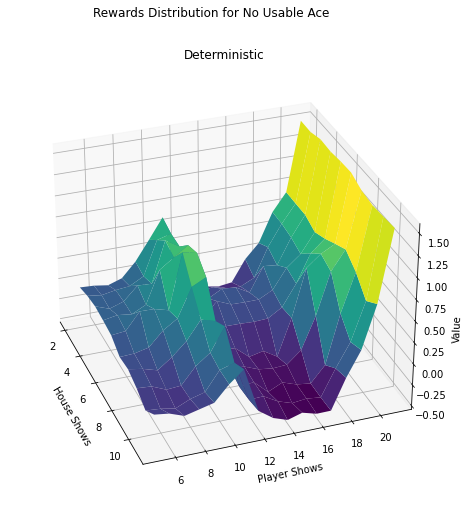

In [14]:
fig = plt.figure(figsize=(15,8))
fig.suptitle('Rewards Distribution for No Usable Ace')
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Deterministic')

noAceMesh = value_det[0][5:,2:]
x,y = np.meshgrid(range(2,12),range(5,22))
ax.plot_surface(x, y, noAceMesh, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
ax.view_init(azim=-20)
ax.set_xlabel('House Shows')
ax.set_ylabel('Player Shows')
ax.set_zlabel('Value')
plt.show()

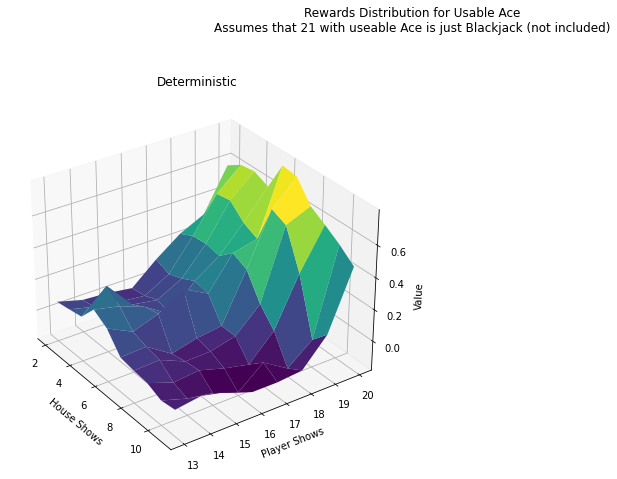

In [15]:
fig = plt.figure(figsize=(15,8))
fig.suptitle('Rewards Distribution for Usable Ace\nAssumes that 21 with useable Ace is just Blackjack (not included)')
ax = fig.add_subplot(121, projection='3d')
ax.set_title('Deterministic')

usableAceMesh = value_det[1][13:21,2:]
x,y = np.meshgrid(range(2,12),range(13,21))

ax.plot_surface(x, y, usableAceMesh, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
ax.view_init(azim=-35)
ax.set_xlabel('House Shows')
ax.set_ylabel('Player Shows')
ax.set_zlabel('Value')
plt.show()

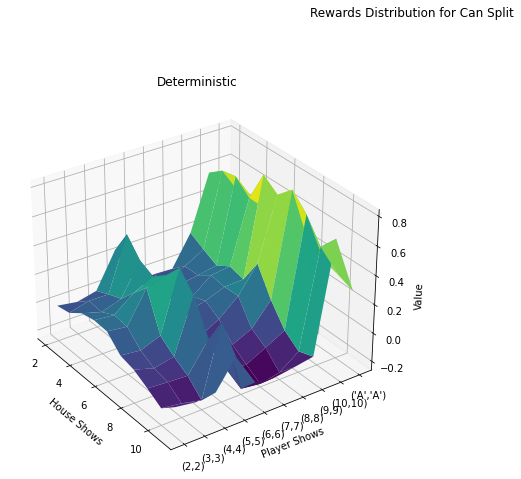

In [16]:
fig = plt.figure(figsize=(15,8))
fig.suptitle('Rewards Distribution for Can Split')
ax = fig.add_subplot(121, projection='3d')
ax.set_title('Deterministic')

canSplitMesh = value_det[2][2:12,2:]
x,y = np.meshgrid(range(2,12),range(2,12))
ticks = ["({},{})".format(p,p) if p < 11 else "('A','A')" for p in range(2,12)]
ax.set(yticks=range(2,12), yticklabels=ticks)
ax.plot_surface(x, y, canSplitMesh, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
ax.view_init(azim=-35)
ax.set_xlabel('House Shows')
ax.set_ylabel('Player Shows')
ax.set_zlabel('Value')
plt.show()

In [275]:
colorMap = {'St':'blue','Hi':'green','Do':'red','Su':'grey','Sp':'yellow'}
noAce = pd.DataFrame(fill[0])
noAce = noAce.iloc[5:][range(2,12)].style.applymap(lambda x: 'background-color: %s' % colorMap[x])
noAce

,2,3,4,5,6,7,8,9,10,11
5,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
6,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
7,Hi,Hi,Hi,Hi,Do,Hi,Hi,Hi,Hi,Hi
8,Hi,Hi,Do,Hi,Do,Hi,Hi,Hi,Hi,Hi
9,Do,Do,Do,Do,Hi,Do,Hi,Hi,Hi,Hi
10,Do,Do,Do,Do,Do,Do,Do,Hi,Hi,Hi
11,Do,Do,Do,Do,Do,Do,Hi,Do,Do,Do
12,Hi,Hi,Hi,Do,St,Hi,Hi,Hi,Hi,Hi
13,Hi,St,St,St,St,Hi,Hi,Hi,Hi,Hi
14,Hi,St,St,St,St,Hi,Hi,Hi,Hi,Su


In [276]:
usableAce = pd.DataFrame(fill[1])
usableAce = usableAce.iloc[13:21][range(2,12)].style.applymap(lambda x: 'background-color: %s' % colorMap[x])
usableAce

,2,3,4,5,6,7,8,9,10,11
13,Hi,Do,Hi,Do,Do,Hi,Hi,Hi,Hi,Hi
14,Hi,Do,Do,Do,Do,Do,Hi,Hi,Hi,Do
15,Hi,Hi,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
16,Hi,Hi,St,Hi,Do,Hi,Hi,Hi,Hi,Hi
17,Do,Do,St,Do,Do,Hi,Hi,Hi,Hi,Hi
18,St,St,Do,Do,Do,St,St,St,Hi,Hi
19,St,St,Do,St,St,St,St,St,St,St
20,St,St,St,St,St,St,St,St,St,St


In [277]:
canSplit = pd.DataFrame(fill[2])
canSplit = canSplit.iloc[2:12][range(2,12)]
canSplit.index = [(p,p) if p < 11 else ('A','A') for p in range(2,12)]
canSplit = canSplit.style.applymap(lambda x: 'background-color: %s' % colorMap[x])
canSplit

,2,3,4,5,6,7,8,9,10,11
"(2, 2)",Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi,Sp,Sp
"(3, 3)",Sp,Sp,Sp,Sp,Sp,Sp,Hi,Sp,Sp,Sp
"(4, 4)",Hi,Hi,Do,Do,Do,Hi,Hi,Hi,Sp,Hi
"(5, 5)",Do,Do,Do,Do,Do,Do,Do,Do,Do,Do
"(6, 6)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp
"(7, 7)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp
"(8, 8)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp
"(9, 9)",St,St,Sp,Sp,St,St,St,Sp,Sp,Sp
"(10, 10)",St,St,St,St,St,St,St,St,St,St
"('A', 'A')",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp


### While I intuitively don't completely agree with all the "best actions" as defined by our Q function (ie. doubling on soft 13?), we are able to achieve a somewhat optimal gameplay through the SARSA Q Learning process.

## Next, I want to incorporate "card count" into the model. This makes the space too large. The solution to this is approximating the Q learning function, through deep learning methods.